In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [94]:
from tensorflow.python.keras.applications import ResNet50
import warnings
warnings.filterwarnings('ignore')

In [95]:
model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=7)

In [ ]:
model.summary()

In [97]:
from tensorflow.python.keras.layers import Dense,Flatten
from tensorflow.python.keras.models import Model

out = model.output
x = Flatten()(out)
out2 = Dense(7, activation='softmax')(x)
c_model = Model(model.input, out2)

In [ ]:
c_model.summary()

In [99]:
import pandas as pd

data = pd.read_csv('./dataset.csv',index_col=0)
data.head(2)

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
1,H01_00716_01,F,A1,0개월,52.0,3.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [100]:
pwd

'/home/ncp/workspace/code'

In [101]:
data_ = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

In [102]:
data_.head()

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,orginal_png_file,crop_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H05_00019_02.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
1,H01_00716_01,F,A1,0개월,52.0,3.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H01_00716_01.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
2,H03_00172_01,F,A1,0개월,42.0,1.8,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H03_00172_01.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
3,H05_00204_01,M,A1,0개월,50.5,3.0,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H05_00204_01.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4
4,H04_00178_01,F,A1,0개월,30.0,0.5,Diffuse hazziness in both lungs. ETT insertion...,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H04_00178_01.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [163]:
def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data_['diagnosis'] = data_['diagnosis'].apply(normal_dia)

In [12]:
dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

In [13]:
import numpy as np

def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)

In [108]:
def read_img(og_img_path, size):
    
    #module import
    import cv2
    import numpy as np
    
    # im_read
    og_img = cv2.imread(og_img_path)
    og_img = cv2.resize(og_img, size)
    return og_img

In [109]:
png_list = list(data_['orginal_png_file'])

In [110]:
X = np.ndarray((4000,224,224,3))
# ZZA ZEUNG NA memory error ..... I'm gonna kill it sib


In [167]:
for i in range(len(X)):
    X[i][:][:][:] = read_img(png_list[i], (224,224))
    
y = np.array(data_['diagnosis'])

In [168]:
import cv2
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

In [169]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [170]:
print(Ytr.shape)
print(Yva.shape)
print(Ytst.shape)

(3200,)
(400,)
(400,)


In [172]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])
c_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [173]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=16,
                                    shuffle=True)
validation_generator = image_datagen.flow(x=Xva,y=Yva_c,
                                         batch_size=16,
                                         shuffle=True)
#image should have rank 4
# image_datagen.fit(Xtr, augment=True, seed=seed)
# mask_datagen.fit(Ytr, augment=True, seed=seed)

# image_generator = image_datagen.flow(Xtr,seed=seed)

# mask_generator = mask_datagen.flow(Ytr,seed=seed)

# combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)


In [174]:
history = c_model.fit_generator(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
200/200 [==============================] - 84s 418ms/step - loss: 1.9197 - acc: 0.2022 - val_loss: 1.8559 - val_acc: 0.2500
Epoch 2/50
200/200 [==============================] - 49s 244ms/step - loss: 1.8355 - acc: 0.2500 - val_loss: 1.8196 - val_acc: 0.2500
Epoch 3/50
200/200 [==============================] - 50s 249ms/step - loss: 1.8125 - acc: 0.2500 - val_loss: 1.8054 - val_acc: 0.2500
Epoch 4/50
200/200 [==============================] - 50s 250ms/step - loss: 1.8029 - acc: 0.2500 - val_loss: 1.7989 - val_acc: 0.2500
Epoch 5/50
200/200 [==============================] - 50s 250ms/step - loss: 1.7988 - acc: 0.2500 - val_loss: 1.7958 - val_acc: 0.2500
Epoch 6/50
200/200 [==============================] - 50s 249ms/step - loss: 1.7966 - acc: 0.2400 - val_loss: 1.7941 - val_acc: 0.2500
Epoch 7/50
200/200 [==============================] - 49s 246ms/step - loss: 1.7954 - acc: 0.2447 - val_loss: 1.7932 - val_acc: 0.2500
Epoch 8/50
200/200 [==============================] - 4

KeyboardInterrupt: 

In [26]:
# history = model.fit(image_generator,Ytr_c, validation_data=[Xva, Yva_c], batch_size=8, epochs=20,verbose=1)

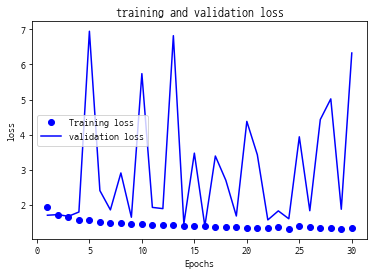

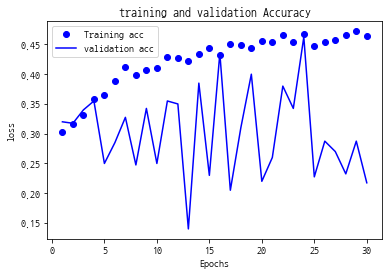

In [26]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
acc= history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
predict = model.predict(Xtst)

In [37]:
predict[0]

array([9.5178139e-01, 4.6908915e-02, 5.4436416e-05, 7.5411452e-05,
       3.6700175e-07, 1.1795604e-03, 1.0523361e-09], dtype=float32)

In [36]:
Ytst_c

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)